<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Musings" data-toc-modified-id="Musings-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Musings</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Trained-Models" data-toc-modified-id="Trained-Models-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Trained Models</a></span></li></ul></li><li><span><a href="#Results-for-focal-loss" data-toc-modified-id="Results-for-focal-loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results for focal loss</a></span></li><li><span><a href="#Metrics-(WIP)" data-toc-modified-id="Metrics-(WIP)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Metrics (WIP)</a></span><ul class="toc-item"><li><span><a href="#Scratch" data-toc-modified-id="Scratch-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Scratch</a></span></li><li><span><a href="#WIP" data-toc-modified-id="WIP-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>WIP</a></span><ul class="toc-item"><li><span><a href="#View-one-result" data-toc-modified-id="View-one-result-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>View one result</a></span></li></ul></li></ul></li></ul></div>

# Summary

Refining previous notebook and experimenting with training. The goal of this nb is to produce an accurate model.

**Journal**
- 2020-11-17 (Tues):
    - Created this nb from a copy of 20201027_coco_C2018_L9 notebook. I want a clean break but also to keep the steps taken in that one (where I moved from "basic" ssd to "moar" and focal loss).
    - Experimented with training models; discovered that loss is a fxn of bs.
    - Last thing I did was train resnet34.

**To do**
- Implement COCO metric

**Training experiments**
- resnet50
- xresnext34 (requires nout param)
- xse_resnext34 (requires nout param)

## Musings

**The anchor box approach**

The idea is to subdivide the image into chunks so we can essentially do many single bbox learners instead of one big multibox. To do this, each image must be subdivided into a grid (or multiple grids), and the labels must be remapped to individual grid cells.

Subdivide the image into cells with a grid. For each cell, generate any number of boxes from it so long as those boxes do not have a higher IOU between them and any other grid cell – the generated boxes must be able to be traced back to their grid cell via IOU. For each box generated, have it perform a 'single labeled bbox' task. Each box generated will produce one result. Keep only the most confident results & prune out any that overlap excessively.

# Data

In [ ]:
from fastai.vision.all import *

# params
im_sz   = 224
bs      = 128
val_pct = .10
sub_pct = .2

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(val_pct),
    item_tfms=Resize(im_sz, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*sub_pct)]
dls = db.dataloaders(subset, bs=bs)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 21999
Size of valid data: 2444
batch[0]: 	 torch.float32 	 torch.Size([128, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([128, 40, 4])
batch[2]: 	 torch.int64 	 torch.Size([128, 40])


# Model

In [ ]:
### Architecture ###
def perm(x,k):
    return x.permute(0,3,2,1).contiguous().view(x.size(0),x.size(2)*x.size(3)*k,x.size(1)//k)
class StdConv(Module):
    """(42:00) Wraps together the standard conv2d → batchnorm → dropout."""
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)

    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
class OutConv(Module):
    """Takes nin inputs, outputs two layers: one for bbs, one for lbls."""
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.bb_acts  = nn.Conv2d(nin, 4*k, 3, padding=1)             
        self.lbl_acts = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1)
        self.lbl_acts.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [perm(self.bb_acts(x), self.k),
                perm(self.lbl_acts(x),self.k)]         
class SSDHead(Module):
    """Wraps StdConv and OutConv into a head module."""
    def __init__(self, k, bias, drop):
        super().__init__()
        self.drop  = nn.Dropout(drop)
        self.conv0 = StdConv(512,256, drop=drop) # most grid cells (4x4 for sz=224)
        self.out0  = OutConv(k,  256, bias)
        self.conv1 = StdConv(256,256, drop=drop)
        self.out1  = OutConv(k,  256, bias)
        self.conv2 = StdConv(256,256, drop=drop) # fewest grid cells (1x1 for sz=224)
        self.out2  = OutConv(k,  256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        bb0,lbl0 = self.out0(x)
        x = self.conv1(x)
        bb1,lbl1 = self.out1(x)
        x = self.conv2(x)
        bb2,lbl2 = self.out2(x)
        return [torch.cat([ bb0, bb1, bb2], dim=1),
                torch.cat([lbl0,lbl1,lbl2], dim=1)]
class CustomModule(Module):
    """Simple class for joining a body and a head."""
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))


### Create Anchors ###
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd) for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)
def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1


### mae, BCE_Loss, and FocalLoss ###
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()].cuda()
class BCELoss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous())
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None 
class FocalLoss(BCELoss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)
    

### iou ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)
def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])
def iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union


### ssd_loss ###
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]
def get_pred_bbs(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb)                        # make acts between -1 and 1
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)          # adjust hw up to 1/2
    return create_anchor_boxes(ctrs, hws)
def map_to_gt(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return bb_idxs, max_iou_per_anc
def ssd_item_loss(act_bbs, act_lbls, bbs, lbls):
    """SSD item loss takes single items from a minibatch, creates hundreds of preds, maps gt
    to the preds, prunes the preds, then calcs & returns the bb and lbl loss for that item."""
    # prep
    bbs,lbls = remove_padding(bbs,lbls)                  # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs, anchors, box_size)  # assemble the ~200 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = iou(bbs.data, anchor_boxes.data)       # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid) # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                     # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                    # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                        # only include bb preds that overlap w/a gt obj and
    incl = torch.nonzero(high_iou)[:,0]                  # aren't predicting background
    mapped_lbls[~high_iou] = 0                           # assign gt class of bg to preds w/ low max gt iou
    # compute loss
    bb_loss_val  = bb_loss(pred_bbs[incl], mapped_bbs[incl])
    lbl_loss_val = lbl_loss(act_lbls, mapped_lbls)
    return bb_loss_val, lbl_loss_val
def ssd_loss(b_acts, b_bbs, b_lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for o in zip(*b_acts, b_bbs, b_lbls):
        bb_loss, lbl_loss = ssd_item_loss(*o)
        sum_bb_loss  += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss


### show_bb & ResultShower ###
def show_bb(im, bb, lbl, sz=im_sz, figsz=5, color='white', ctx=None, title=None):
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx:       show_image(im, figsize=[figsz,figsz], title=title, ctx=ctx)
    else:   ctx = show_image(im, figsize=[figsz,figsz], title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort asc
    idx = idx[-top_k:]       # indices of k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count
class ResultShower():
    def __init__(self, dls, lrn, ancs, anc_sz):
        self.dls,self.mod,self.ancs,self.anc_sz = dls,lrn.model.eval(),ancs,anc_sz
        self.batch    = next(iter(dls.cpu().valid))
        self.acts     = self.mod.cpu()(self.batch[0])
        self.dls.cuda()
        self.mod.cuda()
        self.acts     = [a.data for a in self.acts]
        self.im_size  = self.batch[0].shape[-1]
        self.last_res = 0
        
    def __call__(self, *args, **kwargs):
        return self.show_results(*args, **kwargs)
    
    def acts_to_preds(self, act_bb, act_lbl, overlap=.5, conf=.2):
         # convert acts to preds
        pred_bb  = get_pred_bbs(act_bb, self.ancs, self.anc_sz)
        pred_lbl = act_lbl.max(1)[1]
        lbl_conf = act_lbl.max(1)[0].sigmoid().data
        # filter out preds w/ nms
        nms_idxs, nms_n = nms(pred_bb.data, lbl_conf, overlap)
        nms_idxs = nms_idxs[:nms_n]
        pred_bb  = pred_bb[nms_idxs]
        pred_lbl = pred_lbl[nms_idxs]
        lbl_conf = lbl_conf[nms_idxs]
        # filter out bg and low-conf preds
        is_not_bg = (pred_lbl!=0)
        is_confident = lbl_conf > conf
        mask = is_not_bg & is_confident
        return pred_bb[mask], pred_lbl[mask]
    
    def get_batch_results(self):
        pred_bbs, pred_lbls = [], []
        for _,bb,lbl,act_bb,act_lbl in zip(*self.batch, *self.acts):
            pred_bb, pred_lbl = self.acts_to_preds(act_bb,act_lbl)
            pred_bbs  += [pred_bb]
            pred_lbls += [pred_lbl]
        return pred_bbs, pred_lbls
    
    def show_results(self, n=4, overlap=.5, conf=.1, figsz=12):
        ims = self.dls.decode(self.batch)[0]
        _,bbs,lbls = self.batch
        act_bbs,act_lbls = self.acts
        pred_bbs, pred_lbls = self.get_batch_results()
        for i in range(n):
            j = self.last_res + i
            ctx = get_grid(2, figsize=[figsz,figsz])
            show_bb(ims[j], bbs[j], dls.vocab[lbls[j]], sz=self.im_size, ctx=ctx[0]);
            show_bb(ims[j], pred_bbs[j], dls.vocab[pred_lbls[j]], sz=self.im_size, color='magenta', ctx=ctx[1]);
        self.last_res+=n

# Train

In [ ]:
# init ancs
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# init learner
bb_loss = mae
lbl_loss = FocalLoss(len(dls.vocab))
mod = CustomModule(create_body(resnet34, pretrained=True), SSDHead(k, -4., drop=.4))
learner = Learner(dls, mod, loss_func=ssd_loss) #, metrics=met)

# train
learner.freeze()
# lr_min,lr_max = learner.lr_find()

In [ ]:
# learner.fit_one_cycle(3, lr=(lr_min+lr_max)/2)

# learner.export('models/20201117_coco_ssd_resnet34_50pct.pkl')

# learner.save('s1')

# learner.final_record[1]/bs

## Trained Models

2020-11-16
- `'models/20201116_coco_ssd_moar_53.pkl'`
    - valid loss: 53
    - 5 epochs with one layer frozen
    - lr: 2e-3
    - first time trained with perm instead of flatten_loss
- `'models/20201116_coco_focal_47.pkl'`
    - valid loss: 47
    - 5 epochs with two layers frozen
    - lr: 3e-3
    - first time trained with perm instead of flatten_loss
    - deep trained to produce the following model (didn't improve results)

2020-11-17
- **Baseline: resnet34 w/ 10% of data**
    - valid_loss = 100
    - fit_one_cycle(10, lr=2e-3)
    - 48s per epoch
    - resnet34
    - dls.n_cls = 36
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
    - Exported to `models/20201117_coco_ssdfocal_0.pkl`
    - Note: my attempts to unfreeze and train further have been unsuccessful
    - vl/bs = .781
- **xresnet34 w/ 10% of data**
    - Summary
        - Testing **xresnet34** vs the baseline
        - Result: similar or possibly worse
        - valid_loss = 113
    - Training
        - fit_one_cycle(10, lr=3e-3)
        - 52s per epoch
    - Data
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = .1
        - n_cls = 38
- **xresnet34 w/ 20% of data**
    - valid_loss = 111
    - fit_one_cycle(5, lr=3e-3)
    - 1:40 per epoch (wasn't it taking 2:40 earlier? is this due to batch size?)
    - data params
        - im_size    = 224
        - batch_size = 128
        - valid_pct  = .10
        - subset_pct = **.2**
- **resnet34 w/ 10% of data & bs=64**
    - I'm running this to see if I get better results than the baseline with a lower bs
        - Oh baby, I'm getting a lower loss, but I see now that *loss sums over the batch!* Lower bs will almost always have lower loss.
        - For example, the starting valid loss is 80, which is exactly half of the starting loss from the sessions with a larger bs.
        - I need a metric! I suppose I can use valid_loss/bs for now?
    - valid_loss = 53
    - fit_one_cycle(5, lr=3e-3) 
    - data params
        - im_sz   = 224
        - bs      = **64**
        - val_pct = .10
        - sub_pct = .10
- **resnet34 fine_tune**
    - Testing fine_tune vs fit_one_cycle. I expect fine_tune to outperform.
    - Result: fine_tune did not improve the result and required an additional epoch to match the above model's loss.
    - valid_loss = 54
    - **fine_tune**(3, freeze_epochs=3, lr=slice(lr/100,lr))
    - data params
        - im_sz   = 224
        - bs      = 64
        - val_pct = .10
        - sub_pct = .10
- **resnet34 w/ 50% of data**
    - Let's see how much more data helps the result.
    - Result: 88
        - best valid_loss on 7th epoch (vl = 86)
        - started overfitting on 8th epoch (vl = 87)
    - vl/bs = .685
    - fit_one_cycle(10, lr=(lr_min+lr_max)/2)
    - 227s per epoch
    - lr = 3.6e-3
    - data params
        - im_sz   = 224
        - bs      = 128
        - val_pct = .10
        - sub_pct = **.50**
    - Exported to `models/20201117_coco_ssd_resnet34_50pct.pkl`

# Results for focal loss

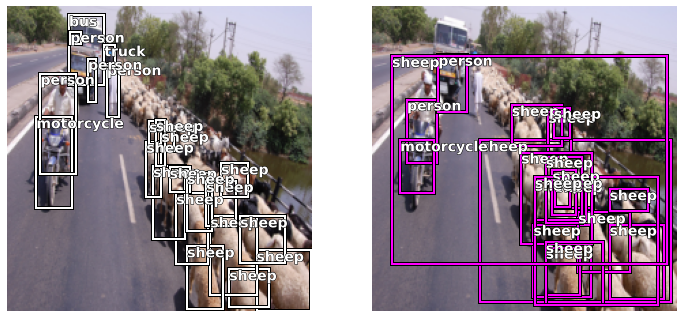

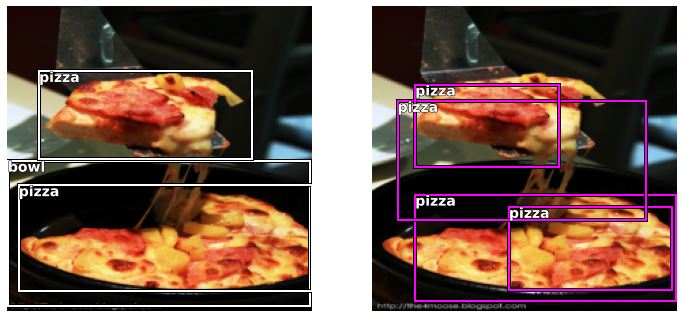

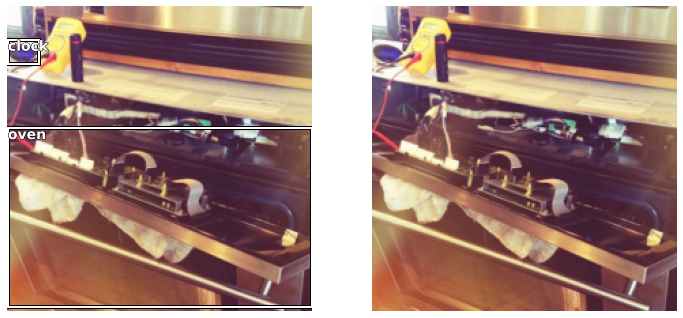

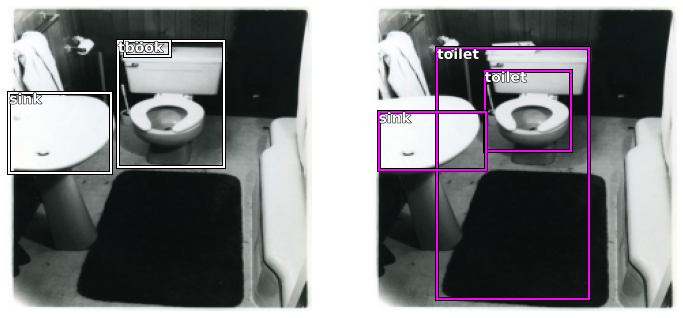

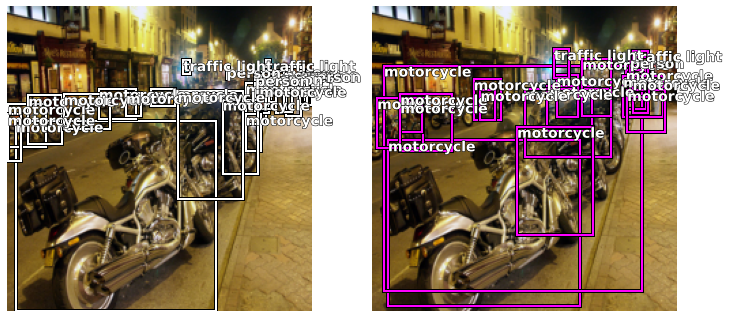

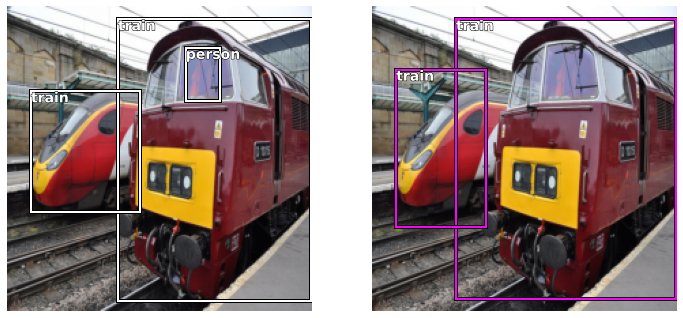

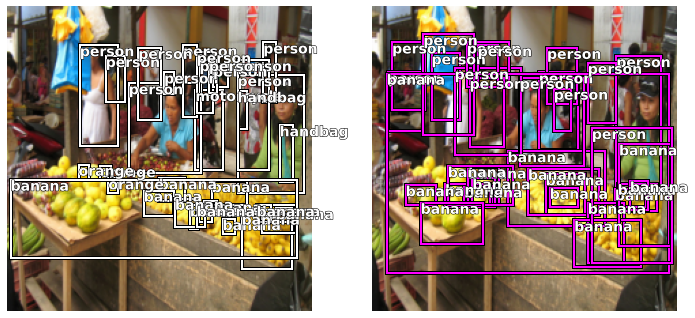

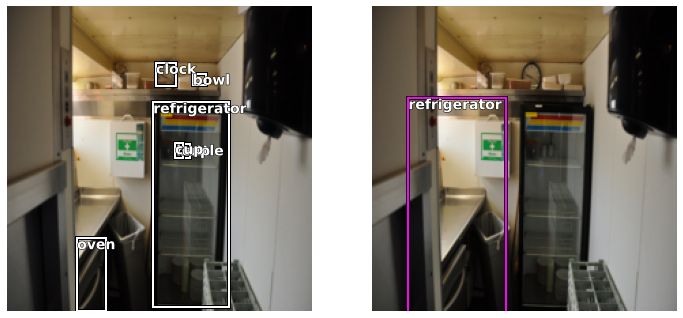

In [ ]:
learner50 = load_learner('models/20201117_coco_ssd_resnet34_50pct.pkl') # 20201117_coco_ssdfocal_0
res50 = ResultShower(dls, learner50, anchors.cpu(), box_size.cpu())
res50(8)

# Metrics (WIP)

## Scratch

In [ ]:
class MeanAveragePrecision(Metric):
    
    @property
    def name(self): return "mAP"
        
    def reset(self):
        self.res = []
        
    def accumulate(self, learn):
        self.res.append(1)
        
    @property
    def value(self):
        return sum(self.res)
met = MeanAveragePrecision()

In [ ]:
# # youtube video mAP implementation
# import torch
# from collections import Counter

# def mean_avg_precision(pred_bbs, gt_bbs, n_cls, iou_thresh=.5):
#     """Source: https://www.youtube.com/watch?v=FppOzcDvaDI"""
#     # pred_bbs (lol): [[img_idx, pred_lbl, conf, *pred_bb], ...]
#     avg_precisions = []
#     eps = 1e-6 # for numerical stability
    
#     for c in range(n_cls):
#         # store pred_bbs and gt_bbs for current class
#         preds = []
#         gts = []
        
#         for pred_bb in pred_bbs:
#             if pred_bb[1] == c: preds.append(pred_bb)
#         for gt_bb in gt_bbs:
#             if gt_bb[1] == c: gts.append(gt_bb)
        
#         # im0 has 1 bb and im1 has 3 bbs
#         # amount_bbs = {0:1, 1:3}
#         # amount_bbs = {0:tensor([0]), 1:tensor([0,0,0])}
#         amount_bbs = Counter([gt[0] for gt in gts])
#         for key,val in amount_bbs.items():
#             amount_bbs[key] = torch.zeros(val)
            
#         preds.sort(key=lambda x: x[2], reverse=True)
#         tp = torch.zeros((len(preds)))
#         fp = torch.zeros((len(preds)))
#         total_true_bbs = len(gts)
        
#         for pred_idx, pred in enumerate(preds):
#             gt_im = [bb for bb in gts if bb[0] == pred[0]]
#             n_gts = len(gt_im)
#             best_iou = 0       
            
#             for idx, gt in enumerate(gt_im):
#                 iou = get_iou(tensor(pred[3:]), tensor(gt[3:]))
#                 if iou > best_iou: best_iou,best_gt_idx = iou,idx
            
#             # update idx of gtbb to indicate it's been used already
#             if best_iou > iou_thresh:
#                 if amount_bbs[pred[0]][best_gt_idx]==0:
#                     tp[pred_idx] = 1
#                     amount_bbs[pred[0]][best_gt_idx] = 1
#                 else: fp[pred_idx] = 1
#             else: fp[pred_idx] = 1
        
#         # [1,1,0,1,0] → [1,2,2,3,3]
#         tp_csum = torch.cumsum(tp, dim=0)
#         fp_csum = torch.cumsum(tp, dim=0)
#         recalls = tp_csum / (total_true_bbs + eps)
#         precisions = torch.divide(tp_csum, (tp_csum + fp_csum + eps))
#         precisions = torch.cat((torch.tensor([1]), precisions))
#         recalls = torch.cat((torch.tensor([0]), recalls))
#         avg_precision.append(torch.trapz(precisions, recalls))
        
#     return sum(avg_precisions)/ len(avg_precisions)

In [ ]:
# sklearn AP
from sklearn.metrics import average_precision_score

y_true = tensor([0.,1.,1.,1.,0.]) # iou(pred,gt) >= .5
y_conf = tensor([.4,.8,.7,.6,.6]) # conf pred is correct
average_precision_score(y_true, y_conf)

0.9166666666666665

## WIP

In [ ]:
# throw anchors on cpu
anchors = anchors.cpu()
box_size = box_size.cpu()
anchor_boxes = anchor_boxes.cpu()

##### Get batch_preds for AP calc (TP, FP, FN)

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

conf_thresh = .2
iou_thresh  = .5
pd.set_option("display.max_rows", 999)


### helpers ###
def map_acts_annos(act_bbs, act_lbls, bbs, lbls):
    # prep
    bbs,lbls = remove_padding(bbs,lbls)                  # remove gt padding inserted during training
    pred_bbs = get_pred_bbs(act_bbs, anchors, box_size)  # assemble the ~200 pred bbs from acts and ancs
    # map gt to preds
    iou_gt_grid = iou(bbs.data, anchor_boxes.data)       # get iou(gt_bbs,anc_bbs); used to map gt → ancs
    mapped_gt_idx, iou_gt_preds = map_to_gt(iou_gt_grid) # assign each pred an index of a gt object
    mapped_bbs  = bbs[mapped_gt_idx]                     # project gt bbs into pred space
    mapped_lbls = lbls[mapped_gt_idx]                    # project gt lbls into pred space
    # remove low-iou bb preds & set mapped lbl to bg
    high_iou = iou_gt_preds > 0.4                        # note which preds have large gt overlaps
    mapped_lbls[~high_iou] = 0                           # assume preds w/small overlaps are pred'ing bg
    incl = torch.nonzero(high_iou)[:,0]                  # create filter
    return pred_bbs[incl], act_lbls[incl], mapped_bbs[incl], mapped_lbls[incl]

def acts_to_preds(pred_bbs, pred_lbls, mapped_bbs, mapped_lbls, thresh=conf_thresh):
    """Gets pred lbls and conf w/ torch.max(axis=1) & applies nms."""
    # get pred lbls and confs
    p_lbls = pred_lbls.max(1)[1]
    confs  = pred_lbls.max(1)[0].sigmoid().data
    # use nms to filter out low-conf overlaps
    sorted_idxs, nms_n = nms(pred_bbs.data, confs)
    nms_idxs = sorted_idxs[:nms_n]
    p_bbs   = pred_bbs[nms_idxs]
    p_lbls  = p_lbls[nms_idxs]
    gt_bbs  = mapped_bbs[nms_idxs]
    gt_lbls = mapped_lbls[nms_idxs]
    p_confs = confs[nms_idxs]
    return p_bbs, p_lbls, gt_bbs, gt_lbls, p_confs

def get_ap_inputs(p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf):
    uniq_objs, uniq_obj_ids = torch.unique(gt_bbs, dim=0, return_inverse=True)
    n_objs = len(uniq_objs)    # record the number of gt objs are in this im ...
    ap_inputs, obj_ids = [], [] # ... and stop the loop when they're all in obj_ids
    for o in zip(p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf, uniq_obj_ids):
        # if pred conf is above thresh, add it to ap_preds (TPs and FPs)
        if o[-2] > conf_thresh:
            ap_inputs.append((*o[:-1], tensor(1))) # 1 indicates TP or FP
            obj_ids.append(o[-1].item())
            continue
        # if the data in ap_preds has at least one pred per gt obj, we're done (no FNs)
        if   len(set(obj_ids)) >= n_objs: break
        # if we're missing gt objs, we have false negatives; grab them
        elif len(set(obj_ids)) <  n_objs:
            if o[-1] not in obj_ids:
                ap_inputs.append((*o[:-1], tensor(0))) # 0 indicates FN
                obj_ids.append(o[-1].item())
    return ap_inputs

def get_ap_per_cls(batch_data):
    # get y_true
    p_bbs, p_lbls, gt_bbs, gt_lbls, y_conf, is_pos = [torch.stack(o) for o in zip(*batch_data)]
    high_iou = torch.diagonal(iou(p_bbs, gt_bbs)) > iou_thresh
    correct  = p_lbls==gt_lbls
    y_true   = high_iou & correct
    outcomes = (is_pos + y_true) * is_pos # 0:FN, 1:FP, 2:TP
    # compute ap per class
    cls = torch.unique(gt_lbls)
    ap_scores, pr_curves, tpfpfns = [], [], []
    for c in cls:
        yts, ycs, tpfpfns_c = [], [], []
        for yt, yc, lbl, outcome in zip(y_true, y_conf, gt_lbls, outcomes):
            if lbl==c:
                yts.append(yt)
                ycs.append(yc)
                tpfpfns_c.append(outcome.item())
        ap_score = 0 if sum(yts)==0 else average_precision_score(yts,ycs)
        ap_scores.append(ap_score)
        tpfpfns.append(tpfpfns_c)
        pr_curves.append(precision_recall_curve(yts,ycs))
    return ap_scores, tpfpfns, pr_curves, cls


### get ap score ###
batch_data = []
for o in zip(*res50.batch, *res50.acts):
    im, bbs, lbls, act_bbs, act_lbls = o
    mapped_outputs = map_acts_annos(act_bbs, act_lbls, bbs, lbls)
    p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf = acts_to_preds(*mapped_outputs)
    batch_data += get_ap_inputs(p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf)
ap_scores, tpfpfns, pr_curves, cls = get_ap_per_cls(batch_data)
res = sum(ap_scores)/len(ap_scores)
print(res)


### viz in df ###
lbz = list(zip([0,1,2],['FN','FP','TP']))
n_samps = [len(o) for o in tpfpfns]
confmat = [{s:sum([v==i for v in vs]) for i,s in lbz} for vs in tpfpfns]
df = pd.DataFrame({'cls':cls,
                   'Class':dls.vocab[cls],
                   'AP Score':ap_scores,
                   'n':n_samps,
                   'ConfMat':confmat}).sort_values('n',ascending=False)
df

0.5444799216264703


,cls,Class,AP Score,n,ConfMat
47,50,person,0.818409,209,"{'FN': 88, 'FP': 68, 'TP': 53}"
54,57,sheep,0.214833,44,"{'FN': 7, 'FP': 33, 'TP': 4}"
17,19,car,0.097619,28,"{'FN': 14, 'FP': 13, 'TP': 1}"
21,23,chair,0.194444,25,"{'FN': 16, 'FP': 7, 'TP': 2}"
42,45,motorcycle,0.677951,24,"{'FN': 7, 'FP': 9, 'TP': 8}"
11,13,book,0.200000,22,"{'FN': 16, 'FP': 5, 'TP': 1}"
3,4,banana,0.187500,19,"{'FN': 13, 'FP': 5, 'TP': 1}"
67,77,umbrella,1.000000,17,"{'FN': 12, 'FP': 1, 'TP': 4}"
25,27,cup,0.750000,17,"{'FN': 13, 'FP': 2, 'TP': 2}"
28,30,donut,0.759722,16,"{'FN': 5, 'FP': 5, 'TP': 6}"


### View one result

/home/rory/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


0.1


,cls,Class,AP Score,n,ConfMat
4,50,person,0.5,10,"{'FN': 5, 'FP': 4, 'TP': 1}"
0,4,banana,0.0,7,"{'FN': 2, 'FP': 5, 'TP': 0}"
3,47,orange,0.0,3,"{'FN': 1, 'FP': 2, 'TP': 0}"
1,37,handbag,0.0,1,"{'FN': 1, 'FP': 0, 'TP': 0}"
2,45,motorcycle,0.0,1,"{'FN': 0, 'FP': 1, 'TP': 0}"


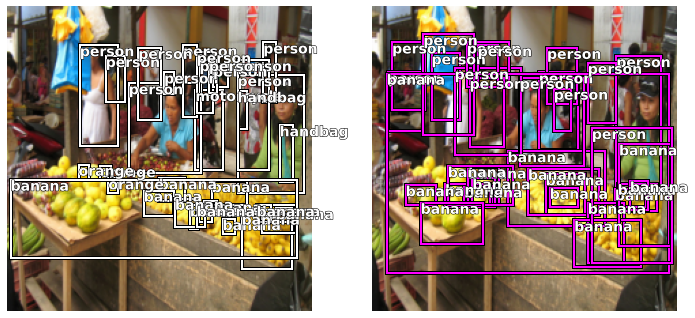

In [ ]:
im, bbs, lbls, act_bbs, act_lbls = list(zip(*res50.batch, *res50.acts))[res50.last_res]
mapped_outputs = map_acts_annos(act_bbs, act_lbls, bbs, lbls)
p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf = acts_to_preds(*mapped_outputs)
batch_data = get_ap_inputs(p_bbs, p_lbls, gt_bbs, gt_lbls, p_conf)

ap_scores, tpfpfns, pr_curves, cls = get_ap_per_cls(batch_data)
res = sum(ap_scores)/len(ap_scores)
print(res)

lbz = list(zip([0,1,2],['FN','FP','TP']))
n_samps = [len(o) for o in tpfpfns]
confmat = [{s:sum([v==i for v in vs]) for i,s in lbz} for vs in tpfpfns]
df = pd.DataFrame({'cls':cls,
                   'Class':dls.vocab[cls],
                   'AP Score':ap_scores,
                   'n':n_samps,
                   'ConfMat':confmat}).sort_values('n',ascending=False)
res50(1)
df

In [ ]:
# left off here. maybe: color bboxes based on tpfpfn